In [12]:
import numpy as np
from data_scripts import load_data
from thermal_solvers import make_thermal_solver_space
from matplotlib import pyplot as plt

N_NEWEST = 5


def only_cpr(path):
    data = load_data(path, n_newest=N_NEWEST)
    results = []
    for sim in data:
        results.extend(
            [val for val in sim if "cpr" in val.config["gmres"]["preconditioner"]]
        )
    return results


data_l = only_cpr("examples/2/thermal_coldstart_l.py")
data_m = only_cpr("examples/2/thermal_coldstart_m.py")
data_s = only_cpr("examples/1/thermal_dynamic.py")

np.random.seed(42)
np.random.shuffle(data_l)

Loading data:
/home/firedrake/workspace/porepy_workspace/solver_selector/examples/2/performance/thermal_coldstart_l_4.npy
/home/firedrake/workspace/porepy_workspace/solver_selector/examples/2/performance/thermal_coldstart_l_5.npy
/home/firedrake/workspace/porepy_workspace/solver_selector/examples/2/performance/thermal_coldstart_l_6.npy
/home/firedrake/workspace/porepy_workspace/solver_selector/examples/2/performance/thermal_coldstart_l_7.npy
/home/firedrake/workspace/porepy_workspace/solver_selector/examples/2/performance/thermal_coldstart_l_8.npy
Loading data:
/home/firedrake/workspace/porepy_workspace/solver_selector/examples/2/performance/thermal_coldstart_m_9.npy
/home/firedrake/workspace/porepy_workspace/solver_selector/examples/2/performance/thermal_coldstart_m_10.npy
/home/firedrake/workspace/porepy_workspace/solver_selector/examples/2/performance/thermal_coldstart_m_11.npy
/home/firedrake/workspace/porepy_workspace/solver_selector/examples/2/performance/thermal_coldstart_m_12.n

In [13]:
from solver_selector.performance_predictor import (
    PerformancePredictorEpsGreedy,
    OnlineStackingRegressor,
)

cpr = make_thermal_solver_space(solver="cpr").get_all_solvers()[0]
predictor_s = PerformancePredictorEpsGreedy(decision_template=cpr)
predictor_s.offline_update(data_s)

predictor_m = PerformancePredictorEpsGreedy(decision_template=cpr)
predictor_m.offline_update(data_m)

mat_size_s = np.log(data_s[0].prediction.context.mat_size)
mat_size_m = np.log(data_m[0].prediction.context.mat_size)
mat_size_l = np.log(data_l[0].prediction.context.mat_size)

mat_size_s, mat_size_m, mat_size_l

(9.574983485564092, 10.181119289134408, 11.790557201568507)

In [14]:
def compare(div):
    data_l_train, data_l_test = data_l[:div], data_l[div:]

    scaling_predictor = OnlineStackingRegressor(
        base_regressors=[predictor_s.regressor, predictor_m.regressor],
        online_regressor=PerformancePredictorEpsGreedy(decision_template=cpr).regressor,
    )

    predictor_l = PerformancePredictorEpsGreedy(
        decision_template=cpr, samples_before_fit=0
    )
    predictor_l.offline_update(data_s)
    predictor_l.offline_update(data_m)
    predictor_l.offline_update(data_l_train)

    predictor_l_test = PerformancePredictorEpsGreedy(
        decision_template=cpr, regressor=scaling_predictor, samples_before_fit=0
    )
    predictor_l_test.offline_update(data_l_train)

    full_contexts_list = []
    rewards_list = []
    for selection_data in data_l_test:
        full_context, rewards = predictor_l_test._prepare_fit_data(selection_data)
        full_contexts_list.append(full_context)
        rewards_list.append(rewards)
    full_contexts = np.concatenate(full_contexts_list)
    rewards = np.concatenate(rewards_list)
    baseline = predictor_l.regressor.score(full_contexts, rewards)
    stacking = predictor_l_test.regressor.score(full_contexts, rewards)
    coefs = list(scaling_predictor.trust_model.coef_) + [
        scaling_predictor.trust_model.intercept_
    ]
    return baseline, stacking, coefs

In [15]:
from tqdm import tqdm

b_list = []
s_list = []
c_list = []
x_list = np.arange(5, 50)
for i in tqdm(x_list):
    baseline, stacking, coefs = compare(div=i)
    b_list.append(baseline)
    s_list.append(stacking)
    c_list.append(coefs)


100%|██████████| 45/45 [00:58<00:00,  1.30s/it]


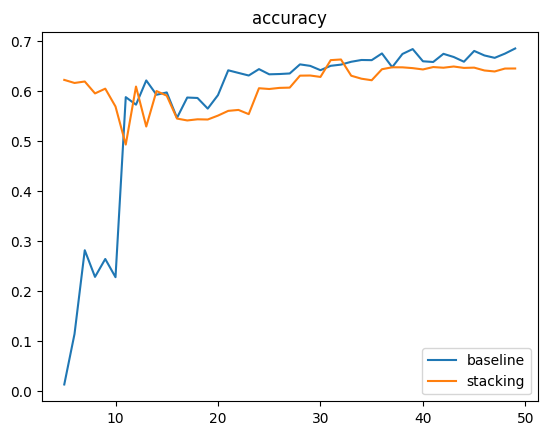

In [16]:
plt.plot(x_list, b_list, label="baseline")
plt.plot(x_list, s_list, label="stacking")
plt.title("accuracy")
# plt.ylim(0, 1)
plt.legend()

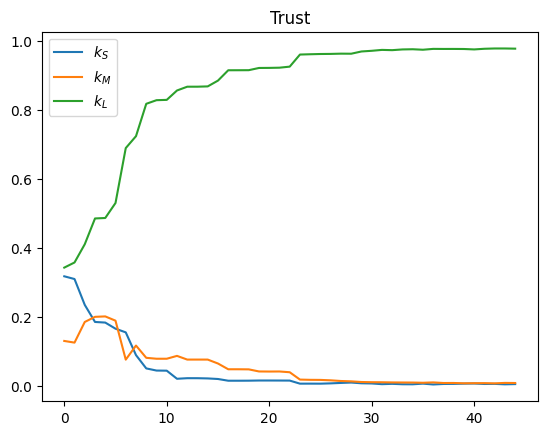

In [17]:
plt.plot(np.array(c_list)[:, 0], label="$k_S$")
plt.plot(np.array(c_list)[:, 1], label="$k_M$")
plt.plot(np.array(c_list)[:, 2], label="$k_L$")
# plt.plot(np.array(c_list)[:, 3], label='$b$')
plt.title("Trust")
# plt.yscale('log')
plt.legend()